# PetFinder.my Adoption Speed Prediction

### Jiaying Du, Siran Fang, Yanan Wu
### May 2020 

The goal of this project is to predict the speed at which a pet is adopted, based on the pet’s profile on PetFinder. Sometimes a profile represents a group of pets. In this case, the speed of adoption is determined by the speed at which all of the pets are adopted. The data include tabular, text, and image data.

In [120]:
# import the packages
import itertools
import re
from collections import Counter
import numpy as np
import pandas as pd
import missingno as msno
from matplotlib import pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, ImageColorGenerator

from langdetect import detect
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim

from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.ensemble import RandomForestClassifier
import eli5

sns.set()
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
SEED = 42

In [2]:
# load the data
# breed, color, state are lookup tables
df = pd.read_csv('data/train/train.csv')
breed = pd.read_csv('data/breed_labels.csv')
color = pd.read_csv('data/color_labels.csv')
state = pd.read_csv('data/state_labels.csv')

In [3]:
df.head(10)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2
5,2,NaN,3,266,0,2,5,6,0,2,1,2,2,2,1,1,0,41326,22fe332bf9c924d4718005891c63fbed,0,This is a stray kitten that came to my house. ...,d24c30b4b,2.0,2
6,2,BULAT,12,264,264,1,1,0,0,2,3,2,2,3,1,1,300,41326,1e0b5a458b5b77f5af581d57ebf570b3,0,anyone within the area of ipoh or taiping who ...,1caa6fcdb,3.0,1
7,1,Siu Pak & Her 6 Puppies,0,307,0,2,1,2,7,2,1,2,2,2,1,6,0,41326,1fba5f6e5480946254590d48f9c5198d,0,Siu Pak just give birth on 13/6/10 to 6puppies...,97aa9eeac,9.0,3
8,2,NaN,2,265,0,2,6,0,0,2,2,2,2,2,1,1,0,41326,d8af7afece71334473575c9f70daf00d,0,"healthy and active, feisty kitten found in nei...",c06d167ca,6.0,1
9,2,Kitty,12,265,0,2,1,7,0,2,2,3,3,3,1,1,0,41326,1f3f36e4b18e94855b3e88af0852fdc4,0,"Very manja and gentle stray cat found, we woul...",7a0942d61,2.0,4


In [4]:
breed.head()

,BreedID,Type,BreedName
0,1,1,Affenpinscher
1,2,1,Afghan Hound
2,3,1,Airedale Terrier
3,4,1,Akbash
4,5,1,Akita


In [5]:
color.head()

,ColorID,ColorName
0,1,Black
1,2,Brown
2,3,Golden
3,4,Yellow
4,5,Cream


In [6]:
state.head()

,StateID,StateName
0,41336,Johor
1,41325,Kedah
2,41367,Kelantan
3,41401,Kuala Lumpur
4,41415,Labuan


## EDA

There are about 15,000 pets in this dataset.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13736 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14993 non-null  int64  
 18  Rescue

Name and Description have missing values.

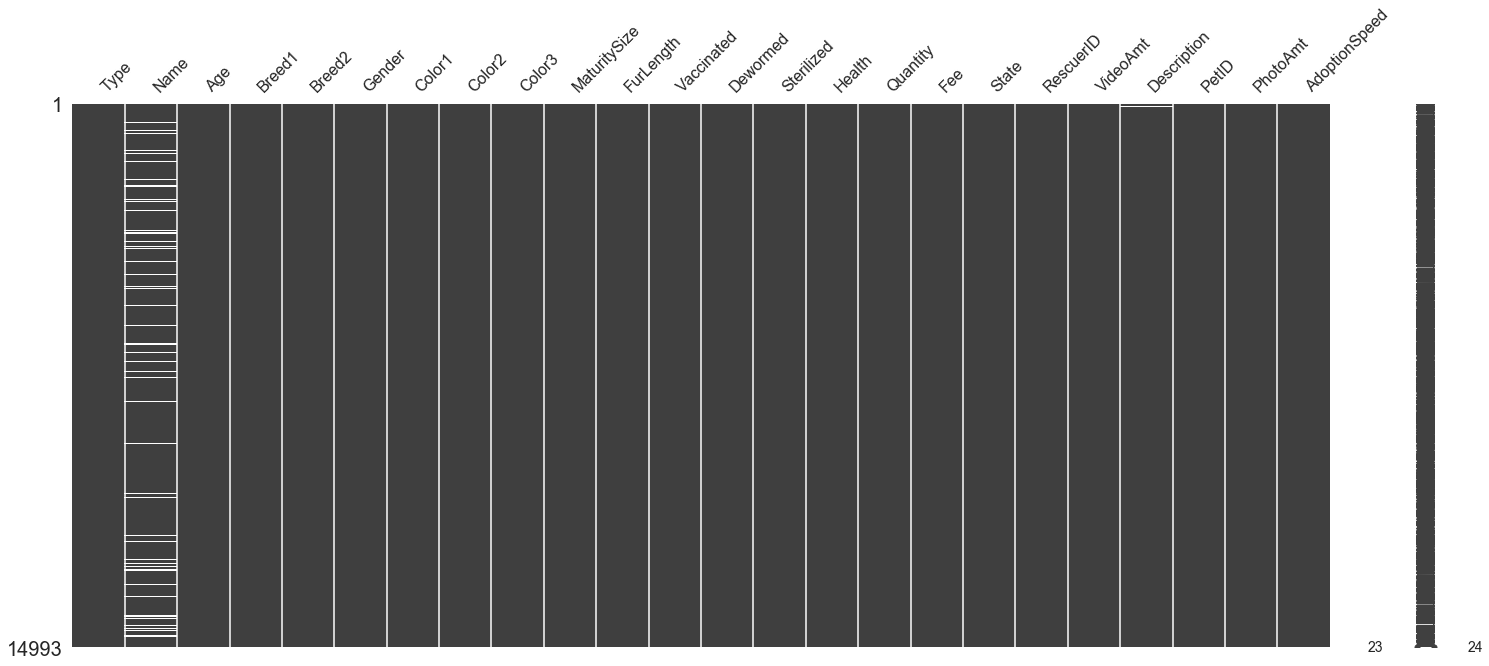

In [8]:
# check missing value
msno.matrix(df)
plt.show()

We have some missing values for Name and Description.

In [9]:
# check missing values
def check_missing(df):
    missing = df.isnull().sum()
    missing_percentage = (df.isnull().sum()/len(df)*100).round(2)
    missing_val = pd.concat([missing, missing_percentage], axis = 1)
    missing_val.columns = ['Missing Values', '% Missing']
    total_columns = df.shape[1]
    missing_columns = (df.isnull().sum() > 0).sum()
    print('Out of {} columns, {} columns have missing values'.format(total_columns, missing_columns))
    return missing_val

check_missing(df)

Out of 24 columns, 2 columns have missing values


,Missing Values,% Missing
Type,0,0.00
Name,1257,8.38
Age,0,0.00
Breed1,0,0.00
Breed2,0,0.00
Gender,0,0.00
Color1,0,0.00
Color2,0,0.00
Color3,0,0.00
MaturitySize,0,0.00


In [10]:
check_missing(breed)

Out of 3 columns, 0 columns have missing values


,Missing Values,% Missing
BreedID,0,0.0
Type,0,0.0
BreedName,0,0.0


In [11]:
check_missing(color)

Out of 2 columns, 0 columns have missing values


,Missing Values,% Missing
ColorID,0,0.0
ColorName,0,0.0


In [12]:
check_missing(state)

Out of 2 columns, 0 columns have missing values


,Missing Values,% Missing
StateID,0,0.0
StateName,0,0.0


In [13]:
target = df[['AdoptionSpeed']]
id = df[['RescuerID', 'PetID']]
features = df.drop(['AdoptionSpeed', 'RescuerID', 'PetID'], axis=1)
num_cols = features.select_dtypes([np.number])
cat_cols = features.select_dtypes(exclude=[np.number])

In [14]:
num_cols.describe()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,1.457614,10.452078,265.272594,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,1.467485,1.731208,1.558727,1.914227,1.036617,1.576069,21.259988,41346.028347,0.056760,3.889215
std,0.498217,18.155790,60.056818,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,0.599070,0.667649,0.695817,0.566172,0.199535,1.472477,78.414548,32.444153,0.346185,3.487810
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,2.000000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,3.000000
75%,2.000000,12.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,0.000000,5.000000
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,8.000000,30.000000


### Target: AdoptionSpeed

The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way:
- 0 - Pet was adopted on the same day as it was listed.
- 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
- 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
- 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
- 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

Very few pets were adopted on the same day as it was listed.

In [15]:
pd.DataFrame(df.AdoptionSpeed.value_counts(normalize=True)).sort_index()

,AdoptionSpeed
0,0.027346
1,0.206096
2,0.269259
3,0.217368
4,0.279931


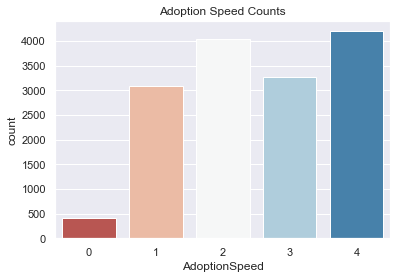

In [16]:
sns.countplot(df.AdoptionSpeed, palette='RdBu') 
plt.title('Adoption Speed Counts')
plt.show()

### Features

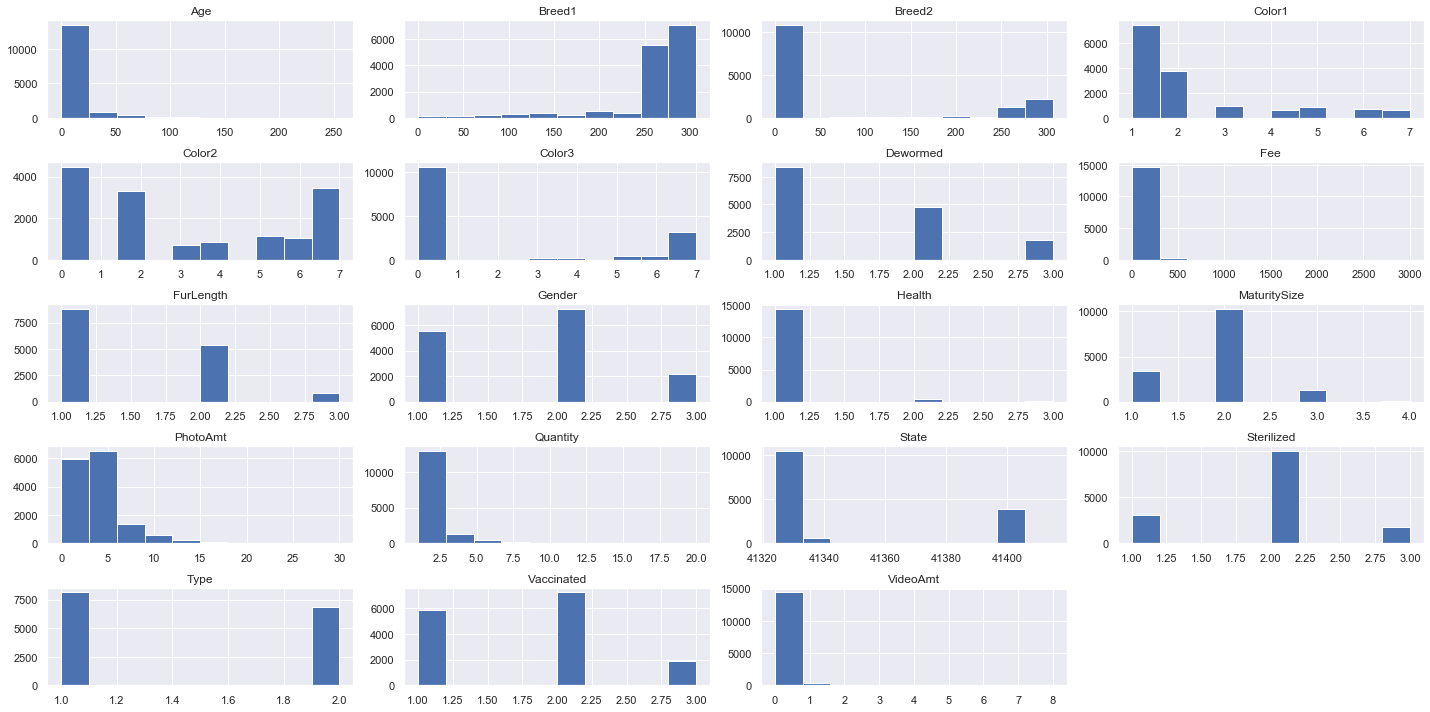

In [17]:
# distribution of all numerical features
num_cols.hist(figsize=(20, 10))
plt.tight_layout()

<b> Type

- 1 - Dog
- 2 - Cat

We have about 8,000 dogs and 7,000 cats in our dataset.

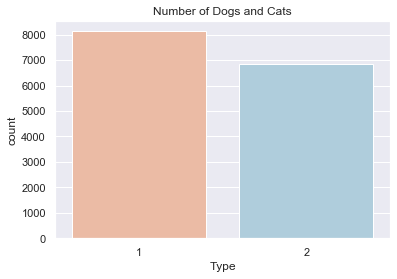

In [18]:
sns.countplot(df.Type, palette='RdBu') 
plt.title('Number of Dogs and Cats')
plt.show()

The average adoption speed of cats is faster than that of dogs.

In [19]:
def comparison_pct_plot(df, count_col, hue_col, title_name):
    g = sns.countplot(x=count_col, data=df, hue=hue_col)
    plt.title(title_name)
    

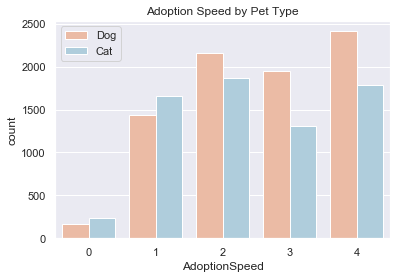

In [20]:
sns.countplot(df.AdoptionSpeed, hue=df.Type, palette='RdBu') 
plt.title('Adoption Speed by Pet Type')
plt.legend(labels=['Dog', 'Cat'])
plt.show()

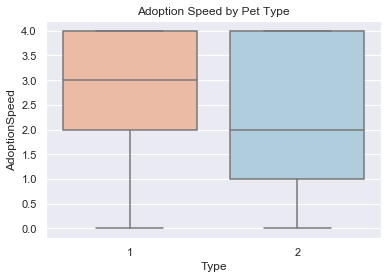

In [21]:
sns.boxplot(df.Type, df.AdoptionSpeed, palette='RdBu')
plt.title('Adoption Speed by Pet Type')
plt.show()

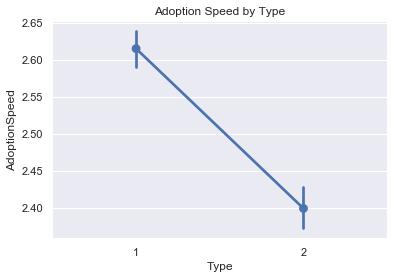

In [22]:
sns.pointplot(df.Type, df.AdoptionSpeed) 
plt.title('Adoption Speed by Type')
plt.show()

<b> Name

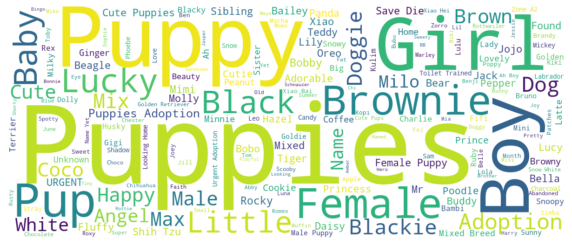

In [23]:
# generate a wordcloud image for dogs' names
dog_names = ' '.join(name for name in df.loc[df.Type==1, 'Name'] if type(name)!=float)
dog_name_wc = WordCloud(background_color='white', width=1200, height=500).generate(dog_names)

plt.figure(figsize=(10,8))
plt.imshow(dog_name_wc, interpolation='bilinear') 
_ = plt.axis('off')
plt.show()

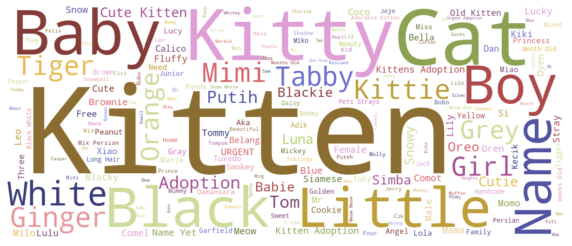

In [24]:
# generate a wordcloud image for cats' names
cat_names = ' '.join(name for name in df.loc[df.Type==2, 'Name'] if type(name)!=float)
cat_name_wc = WordCloud(background_color='white', width=1200, height=500, colormap='tab20b').generate(cat_names)

plt.figure(figsize=(10,8))
plt.imshow(cat_name_wc, interpolation='bilinear') 
_ = plt.axis('off')
plt.show()

<b> Age (in months)

The distribution plot is right skewed. Most of the pets are young.

In [25]:
df.Age.describe()

count    14993.000000
mean        10.452078
std         18.155790
min          0.000000
25%          2.000000
50%          3.000000
75%         12.000000
max        255.000000
Name: Age, dtype: float64

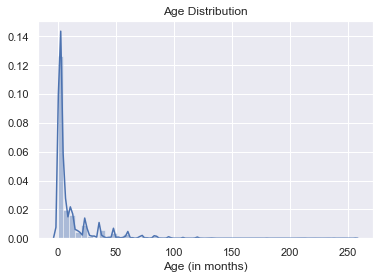

In [26]:
sns.distplot(df.Age)
plt.title('Age Distribution')
plt.xlabel('Age (in months)')
plt.show()

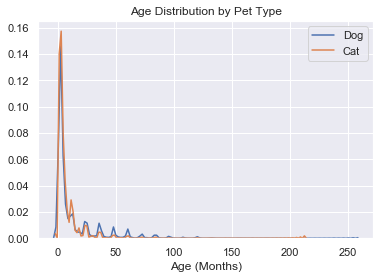

In [27]:
sns.kdeplot(df.loc[df.Type==1, 'Age'], label='Dog')
sns.kdeplot(df.loc[df.Type==2, 'Age'], label='Cat')
plt.title('Age Distribution by Pet Type')
plt.xlabel('Age (Months)')
plt.legend()
plt.show()

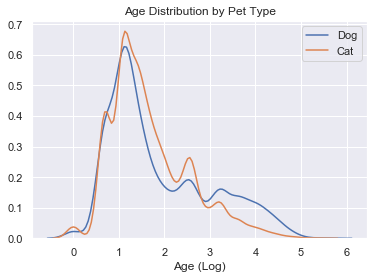

In [28]:
sns.kdeplot(np.log(df.loc[df.Type==1, 'Age']+1), label='Dog')
sns.kdeplot(np.log(df.loc[df.Type==2, 'Age']+1), label='Cat')
plt.title('Age Distribution by Pet Type')
plt.xlabel('Age (Log)')
plt.legend()
plt.show()

The average age of the dogs and the cats in this dataset is about the same.

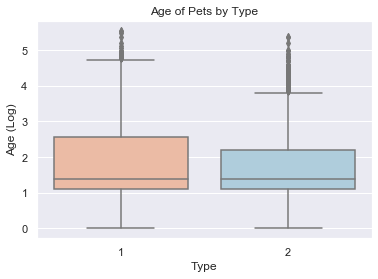

In [29]:
sns.boxplot(df.Type, np.log(df.Age+1), palette='RdBu')
plt.title('Age of Pets by Type')
plt.ylabel('Age (Log)')
plt.show()

Younger pets have a faster adoption speed.

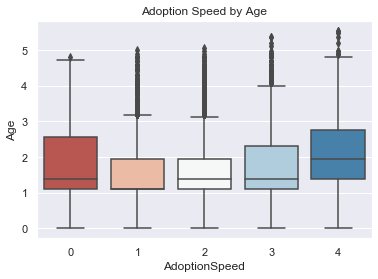

In [30]:
sns.boxplot(df.AdoptionSpeed, np.log(df.Age+1), palette='RdBu')
plt.title('Adoption Speed by Age')
plt.show()

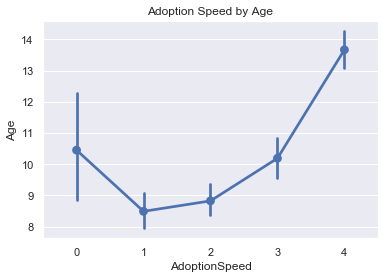

In [31]:
sns.pointplot(df.AdoptionSpeed, df.Age) 
plt.title('Adoption Speed by Age')
plt.show()

<b> Breed

- Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
- Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)

In [32]:
df[['Breed1', 'Breed2']].head()

,Breed1,Breed2
0,299,0
1,265,0
2,307,0
3,307,0
4,307,0


<b> Gender

Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)

In this dataset, we have more females pets than male pets. But male pets were adopted faster.

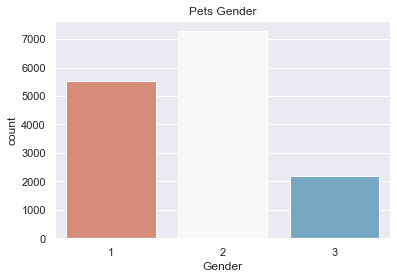

In [33]:
sns.countplot(df.Gender, palette='RdBu') 
plt.title('Pets Gender')
plt.show()

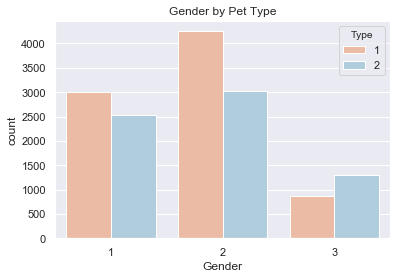

In [34]:
sns.countplot(df.Gender, hue=df.Type, palette='RdBu') 
plt.title('Gender by Pet Type')
plt.show()

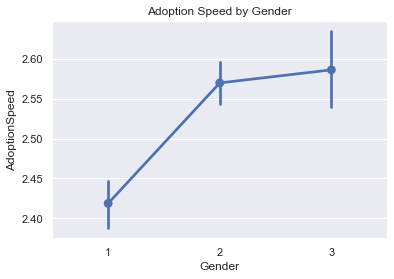

In [35]:
sns.pointplot(df.Gender, df.AdoptionSpeed) 
plt.title('Adoption Speed by Gender')
plt.show()

<b> Color

In [36]:
color

,ColorID,ColorName
0,1,Black
1,2,Brown
2,3,Golden
3,4,Yellow
4,5,Cream
5,6,Gray
6,7,White


In [37]:
color_df = df[['Color1', 'Color2', 'Color3']]
color_df.head()

,Color1,Color2,Color3
0,1,7,0
1,1,2,0
2,2,7,0
3,1,2,0
4,1,0,0


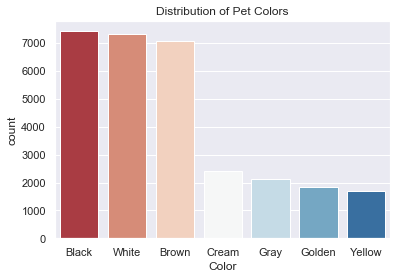

In [38]:
color_values = list(itertools.chain(*color_df.values.tolist()))
color_values = pd.DataFrame(filter(lambda x: x!=0, color_values), columns=['Color'])
color_values = color_values.merge(color, left_on='Color', right_on='ColorID')

sns.countplot(color_values.ColorName, palette='RdBu') 
plt.xlabel('Color')
plt.title('Distribution of Pet Colors')
plt.show()

In [39]:
# check each pet has how many colors
df['ColorNum'] = color_df.astype(bool).sum(axis=1)

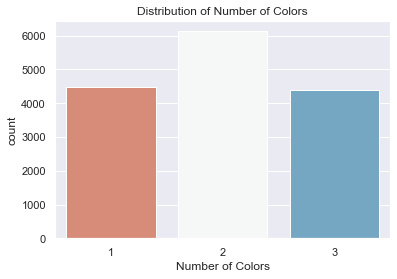

In [40]:
sns.countplot(df.ColorNum, palette='RdBu') 
plt.xlabel('Number of Colors')
plt.title('Distribution of Number of Colors')
plt.show()

Mixed-color pets were adopted faster.

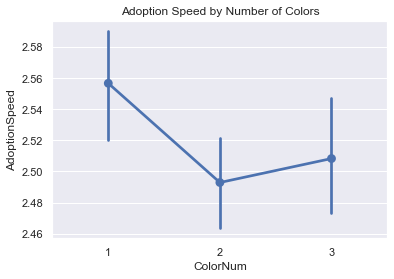

In [41]:
sns.pointplot(df.ColorNum, df.AdoptionSpeed) 
plt.title('Adoption Speed by Number of Colors')
plt.show()

<b> MaturitySize

Size at maturity (1 = small, 2 = medium, 3 = large, 4 = extra large, 0 = not specified)

Most pets are medium size.

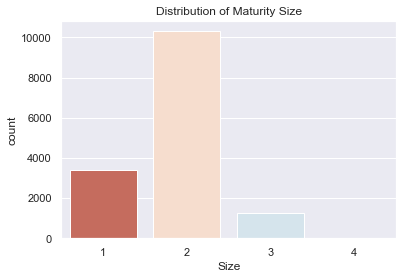

In [42]:
sns.countplot(df.MaturitySize, palette='RdBu') 
plt.xlabel('Size')
plt.title('Distribution of Maturity Size')
plt.show()

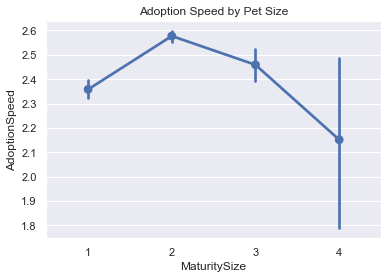

In [43]:
sns.pointplot(df.MaturitySize, df.AdoptionSpeed) 
plt.title('Adoption Speed by Pet Size')
plt.show()

<b> FurLength

Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)

There are more pets with short fur in the datset. But people tend to prefer long fur pets.

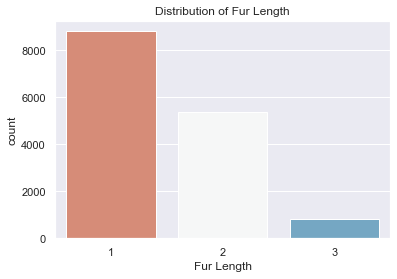

In [44]:
sns.countplot(df.FurLength, palette='RdBu') 
plt.xlabel('Fur Length')
plt.title('Distribution of Fur Length')
plt.show()

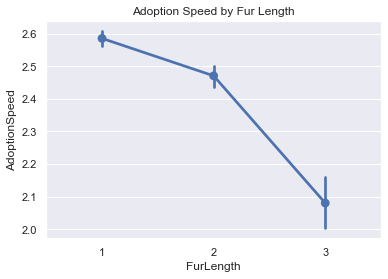

In [45]:
sns.pointplot(df.FurLength, df.AdoptionSpeed) 
plt.title('Adoption Speed by Fur Length')
plt.show()

<b> Vaccinated

Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)

A combination core vaccine containing protection against parvo vi, and unvaccinated pets had a faster adoption speed. The third plot below provides the possible reason that people tend to adopt younger pets, and those pets were not old enough to be vaccinated.us, distemper virus, adenovirus and hepatitis should be given at 8, 10 and 12 weeks of age, and then repeated annually. In this dataset, we have more pets not vaccinated than vaccinated.

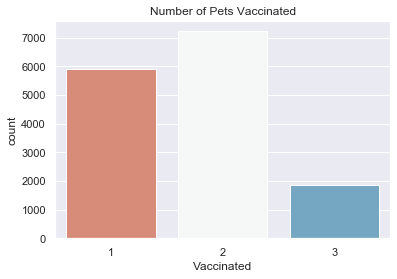

In [46]:
sns.countplot(df.Vaccinated, palette='RdBu') 
plt.title('Number of Pets Vaccinated')
plt.show()

Pets not vaccinated have a faster adoption speed. This is probably because they were adopted when they were small and haven't been vaccinated.

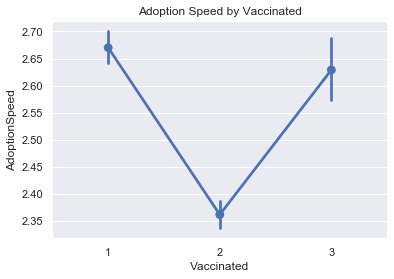

In [47]:
sns.pointplot(df.Vaccinated, df.AdoptionSpeed) 
plt.title('Adoption Speed by Vaccinated')
plt.show()

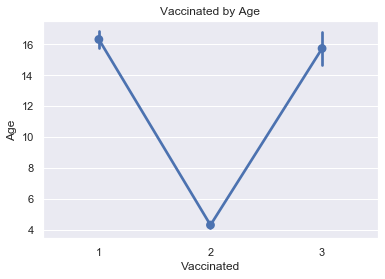

In [48]:
sns.pointplot(df.Vaccinated, df.Age) 
plt.title('Vaccinated by Age')
plt.show()

<b> Dewormed

Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)

Most pets have been dewormed, but they tend to have a slower adoption speed. The possible reason is the same as vaccination. Younger pets tend to be adopted faster and they are not old enough to be dewormed.

De-worming with an oral prescription de-wormer such as pyrantel palmoate or fenbendazole should take place every 2 weeks starting at 3 weeks of age. More pets were dewormed.

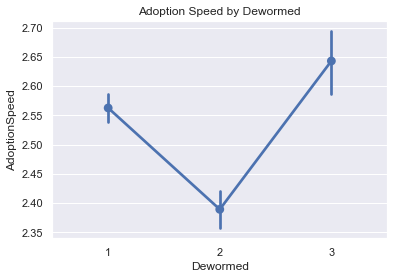

In [49]:
sns.pointplot(df.Dewormed, df.AdoptionSpeed) 
plt.title('Adoption Speed by Dewormed')
plt.show()

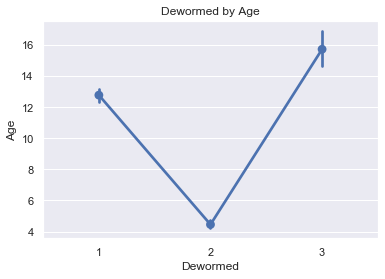

In [50]:
sns.pointplot(df.Dewormed, df.Age) 
plt.title('Dewormed by Age')
plt.show()

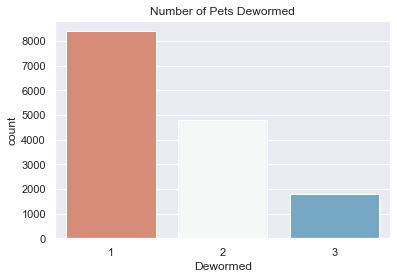

In [51]:
sns.countplot(df.Dewormed, palette='RdBu') 
plt.title('Number of Pets Dewormed')
plt.show()

<b> Sterilized

Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)

Most pets haven't been spayed/neutered, and they have a faster adoption speed.

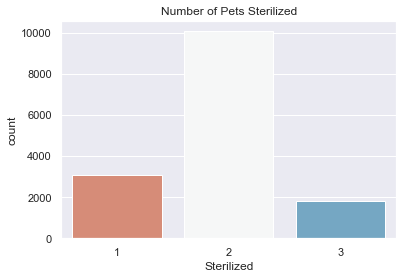

In [52]:
sns.countplot(df.Sterilized, palette='RdBu') 
plt.title('Number of Pets Sterilized')
plt.show()

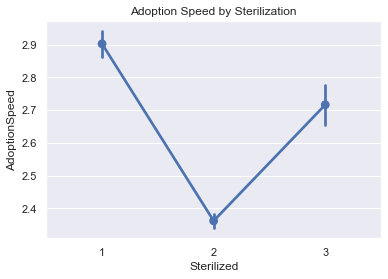

In [53]:
sns.pointplot(df.Sterilized, df.AdoptionSpeed) 
plt.title('Adoption Speed by Sterilization')
plt.show()

<b>Health

Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)

Most pets are healthy. 481 pets have minor injury and 34 pets have serious injury. Healthy pets tend to be adopted faster.

In [54]:
df.Health.value_counts()

1    14478
2      481
3       34
Name: Health, dtype: int64

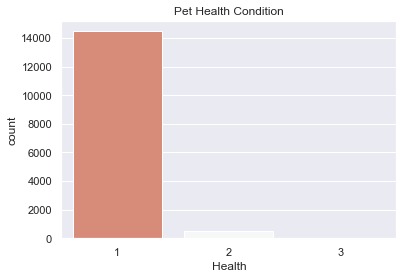

In [55]:
sns.countplot(df.Health, palette='RdBu') 
plt.title('Pet Health Condition')
plt.show()

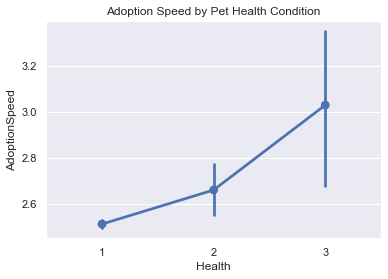

In [56]:
sns.pointplot(df.Health, df.AdoptionSpeed)
plt.title('Adoption Speed by Pet Health Condition')
plt.show()

<b> Quantity

Number of pets represented in profile.

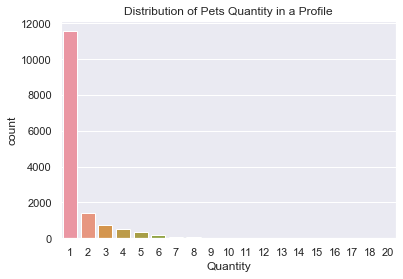

In [57]:
sns.countplot(df.Quantity) 
plt.title('Distribution of Pets Quantity in a Profile')
plt.show()

Profiles with fewer pets have a faster adoption speed.

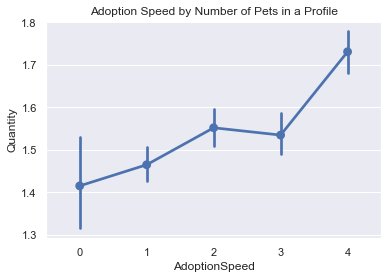

In [58]:
sns.pointplot(df.AdoptionSpeed, df.Quantity)
plt.title('Adoption Speed by Number of Pets in a Profile')
plt.show()

<b> Fee

Adoption fee (0 = Free)

Most pets are free to adopt

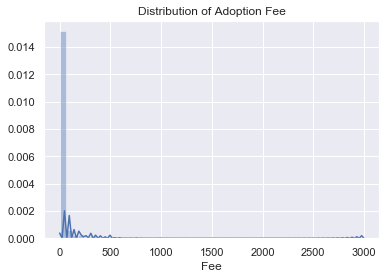

In [59]:
sns.distplot(df.Fee, kde_kws={'bw':0.1}) 
plt.title('Distribution of Adoption Fee')
plt.show()

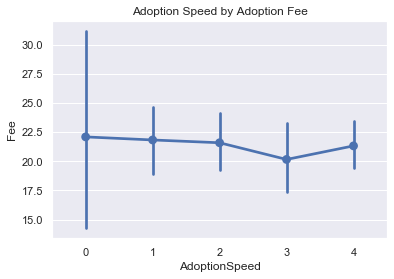

In [60]:
sns.pointplot(df.AdoptionSpeed, df.Fee)
plt.title('Adoption Speed by Adoption Fee')
plt.show()

<b> State

State location in Malaysia (Refer to StateLabels dictionary)

In [61]:
state

,StateID,StateName
0,41336,Johor
1,41325,Kedah
2,41367,Kelantan
3,41401,Kuala Lumpur
4,41415,Labuan
5,41324,Melaka
6,41332,Negeri Sembilan
7,41335,Pahang
8,41330,Perak
9,41380,Perlis


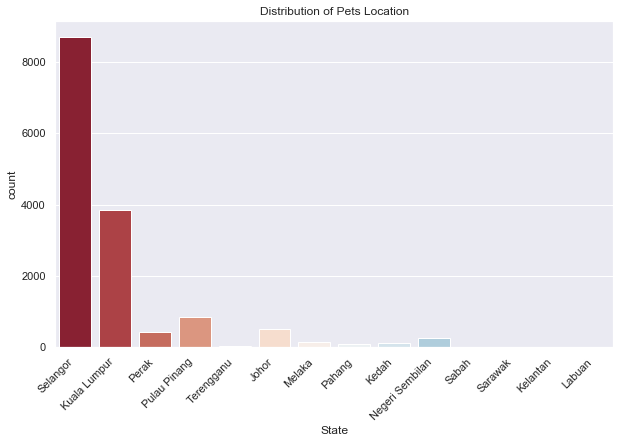

In [62]:
state_df = df[['State']].merge(state, left_on='State', right_on='StateID')

plt.figure(figsize=(10, 6))
g = sns.countplot(state_df.StateName, palette='RdBu') 
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('State')
plt.title('Distribution of Pets Location')
plt.show()

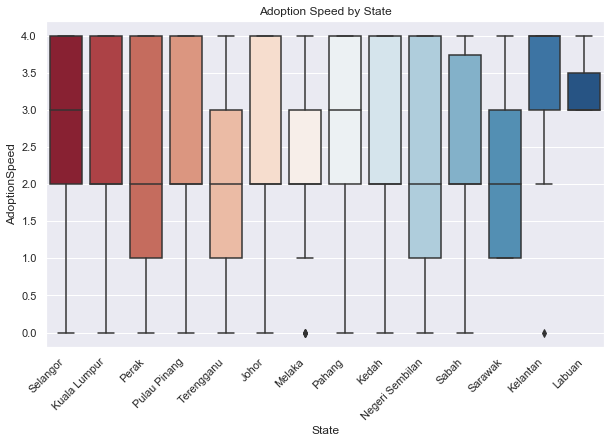

In [63]:
state_df = pd.concat([state_df, df[['AdoptionSpeed']]], axis=1)

plt.figure(figsize=(10, 6))
g = sns.boxplot(state_df.StateName, state_df.AdoptionSpeed, palette='RdBu') 
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('State')
plt.title('Adoption Speed by State')
plt.show()

<b> RescuerID

Unique hash ID of rescuer

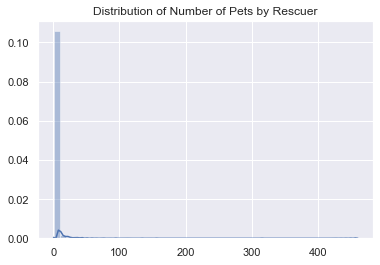

In [64]:
rescuer = df.groupby('RescuerID').size()

sns.distplot(rescuer)
plt.title('Distribution of Number of Pets by Rescuer')
plt.show()

In [65]:
# top rescuers
df.RescuerID.value_counts().head(20)

fa90fa5b1ee11c86938398b60abc32cb    459
aa66486163b6cbc25ea62a34b11c9b91    315
c00756f2bdd8fa88fc9f07a8309f7d5d    231
b53c34474d9e24574bcec6a3d3306a0d    228
ee2747ce26468ec44c7194e7d1d9dad9    156
95481e953f8aed9ec3d16fc4509537e8    134
b770bac0ca797cf1433c48a35d30c4cb    111
a042471e0f43f2cf707104a1a138a7df     95
fd970cc91d06d82eebf046340137b272     93
7ed6d84e2e6879245e55447aee39c328     85
e62135526c27156b8479420aad166317     77
438a9bdce8ef4d5948fc40e422d34d0d     75
8b6c5cd067ada5f54ca5ffc7f7b5d896     74
cccb18b8f8b81862f9a1ebc65d651d22     65
001e42763024f9d4abe31e79472b1827     61
530f57b53cb3199e1d5e67733ddc0876     60
3b074cadd2350de62dca7056b9bab6f4     59
db784cbcf321e1d8856b312638b94113     52
3223e1c4cb2bef48823ee5c604b9aa04     52
9238e4f44c71a75282e62f7136c6b240     50
Name: RescuerID, dtype: int64

<b> VideoAmt

Total uploaded videos for this pet.

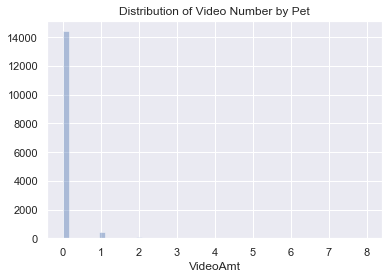

In [66]:
sns.distplot(df.VideoAmt, kde=False) 
plt.title('Distribution of Video Number by Pet') 
plt.show()

In [67]:
df.groupby('AdoptionSpeed')[['VideoAmt']].mean()

,VideoAmt
AdoptionSpeed,
0,0.060976
1,0.044984
2,0.063413
3,0.072722
4,0.046223


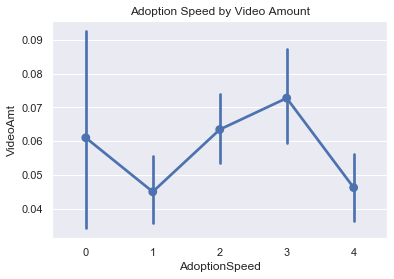

In [68]:
sns.pointplot(df.AdoptionSpeed, df.VideoAmt)
plt.title('Adoption Speed by Video Amount')
plt.show()

<b> PhotoAmt

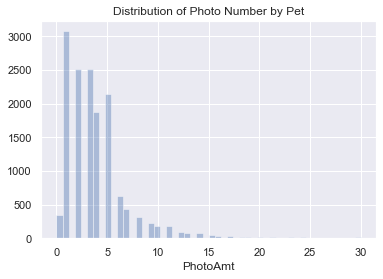

In [69]:
sns.distplot(df.PhotoAmt, kde=False) 
plt.title('Distribution of Photo Number by Pet') 
plt.show()

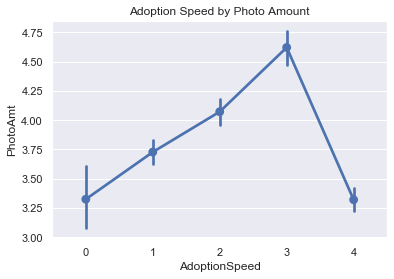

In [70]:
sns.pointplot(df.AdoptionSpeed, df.PhotoAmt)
plt.title('Adoption Speed by Photo Amount')
plt.show()

Total uploaded photos for this pet.

<b> Description

Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

In [71]:
df.Description.head(20)

0     Nibble is a 3+ month old ball of cuteness. He ...
1     I just found it alone yesterday near my apartm...
2     Their pregnant mother was dumped by her irresp...
3     Good guard dog, very alert, active, obedience ...
4     This handsome yet cute boy is up for adoption....
5     This is a stray kitten that came to my house. ...
6     anyone within the area of ipoh or taiping who ...
7     Siu Pak just give birth on 13/6/10 to 6puppies...
8     healthy and active, feisty kitten found in nei...
9     Very manja and gentle stray cat found, we woul...
10    For serious adopter, please do sms or call for...
11    Kali is a super playful kitten who is on the g...
12    Peanut was an abused puppy until he was rescue...
13    Hi Pet Lovers! This is my first posting and I ...
14    Lost Dog Found (Bandar Menjalara, Kepong／Taman...
15    We moved out of our apartment to a landed home...
16              to be spayed on /12 adorable & friendly
17    shes active... she can obey wht command th

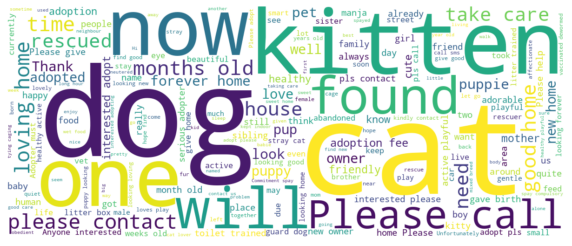

In [72]:
# generate a wordcloud image for description
description_wc = ' '.join(desc for desc in df.Description if type(desc)!=float)
description_wc = WordCloud(background_color='white', width=1200, height=500).generate(description_wc)

plt.figure(figsize=(10,8))
plt.imshow(description_wc, interpolation='bilinear') 
_ = plt.axis('off')
plt.show()

In [73]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), tokenizer=word_tokenize)
vectorizer.fit(df.Description.fillna('').values)
X_train = vectorizer.transform(df.Description.fillna(''))

rf = RandomForestClassifier(n_estimators=20, random_state=SEED)
rf.fit(X_train, df.AdoptionSpeed)

for i in range(5):
    print('Example of Adoption speed {}'.format(i))
    text = df.loc[df.AdoptionSpeed==i, 'Description'].values[0]
    print(text)
    display(eli5.show_prediction(rf, doc=text, vec=vectorizer, top=10))

Example of Adoption speed 0
I just found it alone yesterday near my apartment. It was shaking so I had to bring it home to provide temporary care.


Example of Adoption speed 1
anyone within the area of ipoh or taiping who interested to adopt my cat can contact my father at this number (mazuvil)or can just email me. currently bulat is at my hometown at perak but anyone outside the area still want to adopt can travel there to my hometown.there is a lot of cats in my house rite now..i think i should let one of them go to a better owner who can give better attention to him.


Example of Adoption speed 2
Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.


Example of Adoption speed 3
Their pregnant mother was dumped by her irresponsible owner at the roadside near some shops in Subang Jaya. Gave birth to them at the roadside. They are all healthy and adorable puppies. Already dewormed, vaccinated and ready to go to a home. No tying or caging for long hours as guard dogs. However, it is acceptable to cage or tie for precautionary purposes. Interested to adopt pls call me.


Example of Adoption speed 4
Very manja and gentle stray cat found, we would really like to find a home for it because we cannot keep her for ourselves for long. Has a very cute high pitch but soft meow. Please contact me if you would be interested in adopting.


## Feature Engineering

### Name

About 20% of the pets don't have a name.

In [74]:
# Name
df['NoName'] = 0
df.loc[df['Name'] == 'No Name Yet', 'NoName'] = 1
df.loc[df['Name'] == 'No Name', 'NoName'] = 1
df.loc[df['Name'] == 'Unknown', 'NoName'] = 1
df.loc[df['Name'].isnull(), 'NoName'] = 1
df.loc[df['Name'].str.contains("Name",na = False),'NoName'] = 1
df.loc[df['Name'].str.contains("name",na = False),'NoName'] = 1
df.loc[df['Name'].str.contains("Unknown",na = False),'NoName'] = 1
df.loc[df['Name'].str.len() == 3, 'NoName'] = 1
df.loc[df['Name'].str.len() == 2, 'NoName'] = 1
df.loc[df['Name'].str.len() == 1, 'NoName'] = 1
df.loc[df['Name'].str.contains("Puppies",na = False),'NoName'] = 1
df.loc[df['Name'].str.contains("Doggie",na = False),'NoName'] = 1
df.loc[df['Name'].str.contains("Kitty",na = False),'NoName'] = 1
df.loc[df['Name'].str.contains("Kittens",na = False),'NoName'] = 1
df.loc[df['Name'].str.contains("!",na = False),'NoName'] = 1
df.loc[df['Name'].str.contains("Zone",na = False),'NoName'] = 1

df['NoName'].value_counts()

0    11966
1     3027
Name: NoName, dtype: int64

In [75]:
df['NoName'].value_counts(normalize=True)

0    0.798106
1    0.201894
Name: NoName, dtype: float64

### Pure_Breeds

- About 41.5% of the pets are pure breed.
- The percentage of pure breed cat is much higher than pure breed dog. 
- Pure breed pets are adopted faster.

In [76]:
# create new variable pure_breed/YN, condition based on Pure_Breed
df['PureBreed'] = 0
df.loc[df['Breed2']==0, 'PureBreed'] = 1
df.loc[df['Breed1']==307, 'PureBreed'] = 0

print(f"Rate of pure breed pets in train data: {df['PureBreed'].sum() * 100 / df['PureBreed'].shape[0]:.4f}%.")

Rate of pure breed pets in train data: 41.5327%.


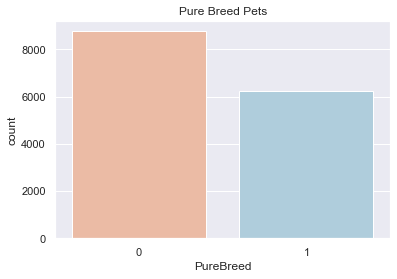

In [77]:
sns.countplot(df['PureBreed'], palette='RdBu')
plt.title('Pure Breed Pets')
plt.show()

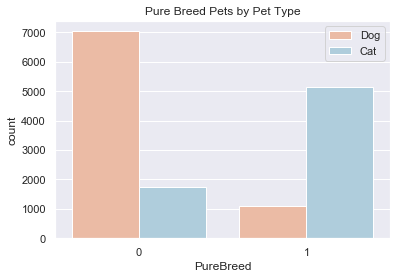

In [78]:
sns.countplot(df['PureBreed'], hue=df.Type, palette='RdBu')
plt.title('Pure Breed Pets by Pet Type')
plt.legend(['Dog', 'Cat'])
plt.show()

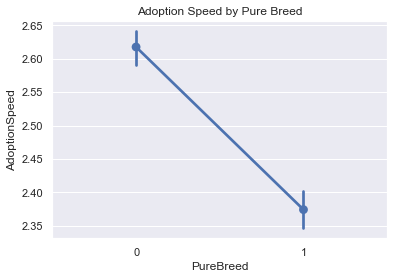

In [79]:
sns.pointplot(df.PureBreed, df.AdoptionSpeed) 
plt.title('Adoption Speed by Pure Breed')
plt.show()

In [80]:
# Pure_BreedScore
df['Pure_BreedScore'] = 0
df.loc[df['PureBreed'] == 1, 'Pure_BreedScore'] = df['Breed1']

In [81]:
breeds_dict = {k: v for k, v in zip(breed['BreedID'], breed['BreedName'])}
df['Pure_BreedName'] = df['Pure_BreedScore'].apply(lambda x: '_'.join(breeds_dict[x].split()) 
                                                   if x in breeds_dict else 'Mixed_Breed')

In [82]:
a = df['Pure_BreedName'].value_counts()
a.head(10)

Mixed_Breed             8766
Domestic_Short_Hair     3058
Domestic_Medium_Hair     984
Tabby                    247
Domestic_Long_Hair       178
Shih_Tzu                 149
Poodle                   121
Siamese                  120
Golden_Retriever          94
Persian                   76
Name: Pure_BreedName, dtype: int64

In [83]:
df['Breed1_name'] = df['Breed1'].apply(lambda x: '_'.join(breeds_dict[x].split()) 
                                                   if x in breeds_dict else 'Other')
df['Breed2_name'] = df['Breed2'].apply(lambda x: '_'.join(breeds_dict[x].split()) 
                                                   if x in breeds_dict else 'Pure')

In [84]:
df_1 = pd.get_dummies(df['Breed1_name'])
df_2 = pd.get_dummies(df['Breed2_name'])

In [85]:
a = df_1.columns.difference(df_2.columns)
column2 = ['Airedale_Terrier', 'American_Bulldog', 'American_Water_Spaniel',
       'American_Wirehair', 'Australian_Kelpie', 'Bedlington_Terrier',
       'Black_Labrador_Retriever', 'Black_Mouth_Cur', 'Boston_Terrier',
       'Burmilla', 'Cattle_Dog', 'Chinese_Crested_Dog',
       'Chocolate_Labrador_Retriever', 'Coonhound', 'Dutch_Shepherd',
       'English_Bulldog', 'English_Pointer', 'English_Springer_Spaniel',
       'Extra-Toes_Cat_(Hemingway_Polydactyl)', 'Field_Spaniel',
       'Flat-coated_Retriever', 'Foxhound', 'French_Bulldog', 'German_Spitz',
       'Glen_of_Imaal_Terrier', 'Greyhound', 'Irish_Terrier',
       'Irish_Wolfhound', 'Javanese', 'Kai_Dog', 'Kuvasz', 'Lancashire_Heeler',
       'Lhasa_Apso', 'Manchester_Terrier', 'Mountain_Dog',
       'Norwegian_Forest_Cat', 'Ocicat', 'Old_English_Sheepdog', 'Pixie-Bob',
       'Ragamuffin', 'Rat_Terrier', 'Scottish_Terrier_Scottie', 'Setter',
       'Somali', 'Sphynx_(hairless_cat)', 'Staffordshire_Bull_Terrier',
       'Standard_Poodle', 'Swedish_Vallhund', 'Toy_Fox_Terrier',
       'West_Highland_White_Terrier_Westie', 'Wheaten_Terrier', 'Whippet',
       'White_German_Shepherd']

d = dict.fromkeys(column2, 0)
df_2 = df_2.assign(**d)
df_2 = df_2.drop(['Pure'], axis=1)

In [86]:
b = df_2.columns.difference(df_1.columns)
column1 = ['Afghan_Hound', 'Akbash', 'Australian_Cattle_Dog/Blue_Heeler',
       'Bluetick_Coonhound', 'Border_Terrier', 'Finnish_Spitz',
       'German_Shorthaired_Pointer', 'Harrier', 'Munchkin', 'Norfolk_Terrier',
       'Selkirk_Rex', 'Smooth_Fox_Terrier']
df_1 = df_1.assign(**dict.fromkeys(column1, 0))
df_1 = df_1.drop(['Other'], axis=1)

In [87]:
df_cob = df_1 + df_2
df_cob.head()

,Abyssinian,Affenpinscher,Afghan_Hound,Airedale_Terrier,Akbash,Akita,American_Bulldog,American_Curl,American_Shorthair,American_Staffordshire_Terrier,American_Water_Spaniel,American_Wirehair,Applehead_Siamese,Australian_Cattle_Dog/Blue_Heeler,Australian_Kelpie,Australian_Shepherd,Australian_Terrier,Balinese,Basenji,Basset_Hound,Beagle,Bearded_Collie,Bedlington_Terrier,Belgian_Shepherd_Dog_Sheepdog,Belgian_Shepherd_Laekenois,Belgian_Shepherd_Malinois,Bengal,Birman,Black_Labrador_Retriever,Black_Mouth_Cur,Bluetick_Coonhound,Bobtail,Bombay,Border_Collie,Border_Terrier,Boston_Terrier,Boxer,British_Shorthair,Bull_Terrier,Bullmastiff,Burmese,Burmilla,Calico,Cattle_Dog,Cavalier_King_Charles_Spaniel,Chartreux,Chausie,Chihuahua,Chinese_Crested_Dog,Chocolate_Labrador_Retriever,...,Rhodesian_Ridgeback,Rottweiler,Russian_Blue,Saint_Bernard,Samoyed,Schnauzer,Scottish_Fold,Scottish_Terrier_Scottie,Selkirk_Rex,Setter,Shar_Pei,Sheep_Dog,Shepherd,Shetland_Sheepdog_Sheltie,Shiba_Inu,Shih_Tzu,Siamese,Siberian,Siberian_Husky,Silky_Terrier,Silver,Singapura,Smooth_Fox_Terrier,Snowshoe,Somali,Spaniel,Sphynx_(hairless_cat),Spitz,Staffordshire_Bull_Terrier,Standard_Poodle,Swedish_Vallhund,Tabby,Terrier,Tiger,Tonkinese,Torbie,Tortoiseshell,Toy_Fox_Terrier,Turkish_Angora,Turkish_Van,Tuxedo,Weimaraner,Welsh_Corgi,West_Highland_White_Terrier_Westie,Wheaten_Terrier,Whippet,White_German_Shepherd,Wirehaired_Terrier,Yellow_Labrador_Retriever,Yorkshire_Terrier_Yorkie
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [88]:
sum_col = pd.DataFrame(df_cob.sum(axis=0), columns=['count'])
a = sum_col.sort_values(['count'], ascending=False)
a.head(10)

,count
Mixed_Breed,7654
Domestic_Short_Hair,4233
Domestic_Medium_Hair,1579
Tabby,480
Domestic_Long_Hair,421
Siamese,369
Persian,299
Labrador_Retriever,291
Terrier,253
Shih_Tzu,222


In [89]:
df_breed = df_cob[["Tabby","Domestic_Short_Hair", "Domestic_Medium_Hair",
                   "Labrador_Retriever","Terrier","Mixed_Breed"]]

df_breed['sum'] = df_breed.sum(axis=1)

In [90]:
df_breed['Other'] = df_breed['sum'].apply(lambda x: 1 if x == 0  else 0)
df_breed = df_breed.drop(['sum'],axis=1)
df_breed.head()

,Tabby,Domestic_Short_Hair,Domestic_Medium_Hair,Labrador_Retriever,Terrier,Mixed_Breed,Other
0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0


In [91]:
df = pd.concat([df, df_breed], axis=1)

In [92]:
df.loc[df['Tabby'] == 2, 'Tabby'] = 1
df.loc[df['Domestic_Short_Hair'] == 2, 'Domestic_Short_Hair'] = 1
df.loc[df['Domestic_Medium_Hair'] == 2, 'Domestic_Medium_Hair'] = 1
df.loc[df['Labrador_Retriever'] == 2, 'Labrador_Retriever'] = 1
df.loc[df['Terrier'] == 2, 'Terrier'] = 1
df.loc[df['Mixed_Breed'] == 2, 'Mixed_Breed'] = 1

### Color

In [93]:
# color
color1_df = df[['Color1']].merge(color, how='left', left_on='Color1', right_on='ColorID')
color1_dummy = pd.get_dummies(color1_df.ColorName, prefix='Color')
color1_dummy.head()

,Color_Black,Color_Brown,Color_Cream,Color_Golden,Color_Gray,Color_White,Color_Yellow
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [94]:
color2_df = df[['Color2']].merge(color, how='left', left_on='Color2', right_on='ColorID')
color2_dummy = pd.get_dummies(color2_df.ColorName, prefix='Color')
color2_dummy.head()

,Color_Brown,Color_Cream,Color_Golden,Color_Gray,Color_White,Color_Yellow
0,0,0,0,0,1,0
1,1,0,0,0,0,0
2,0,0,0,0,1,0
3,1,0,0,0,0,0
4,0,0,0,0,0,0


In [95]:
color3_df = df[['Color3']].merge(color, how='left', left_on='Color3', right_on='ColorID')
color3_dummy = pd.get_dummies(color3_df.ColorName, prefix='Color')
color3_dummy.head()

,Color_Cream,Color_Golden,Color_Gray,Color_White,Color_Yellow
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [96]:
color2_dummy['Color_Black'] = 0
color3_dummy['Color_Black'] = 0
color3_dummy['Color_Brown'] = 0

In [97]:
color_dummy = color1_dummy + color2_dummy + color3_dummy
color_dummy.head()

,Color_Black,Color_Brown,Color_Cream,Color_Golden,Color_Gray,Color_White,Color_Yellow
0,1,0,0,0,0,1,0
1,1,1,0,0,0,0,0
2,0,1,0,0,0,1,0
3,1,1,0,0,0,0,0
4,1,0,0,0,0,0,0


In [98]:
df = pd.concat([df, color_dummy], axis=1)
df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,ColorNum,NoName,PureBreed,Pure_BreedScore,Pure_BreedName,Breed1_name,Breed2_name,Tabby,Domestic_Short_Hair,Domestic_Medium_Hair,Labrador_Retriever,Terrier,Mixed_Breed,Other,Color_Black,Color_Brown,Color_Cream,Color_Golden,Color_Gray,Color_White,Color_Yellow
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,2,0,1,299,Tabby,Tabby,Pure,1,0,0,0,0,0,0,1,0,0,0,0,1,0
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,2,1,1,265,Domestic_Medium_Hair,Domestic_Medium_Hair,Pure,0,0,1,0,0,0,0,1,1,0,0,0,0,0
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,2,0,0,0,Mixed_Breed,Mixed_Breed,Pure,0,0,0,0,0,1,0,0,1,0,0,0,1,0
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,2,0,0,0,Mixed_Breed,Mixed_Breed,Pure,0,0,0,0,0,1,0,1,1,0,0,0,0,0
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,1,0,0,0,Mixed_Breed,Mixed_Breed,Pure,0,0,0,0,0,1,0,1,0,0,0,0,0,0


### State

In [99]:
# merge with the lookup table
state_df = df[['State']].merge(state, left_on='State', right_on='StateID')
state_count = state_df.StateName.value_counts()
state_count

Selangor           8714
Kuala Lumpur       3845
Pulau Pinang        843
Johor               507
Perak               420
Negeri Sembilan     253
Melaka              137
Kedah               110
Pahang               85
Terengganu           26
Sabah                22
Kelantan             15
Sarawak              13
Labuan                3
Name: StateName, dtype: int64

In [100]:
state_other = state_df.StateName.apply(lambda x: 'Other' if x not in state_count.head(5).index else x)
state_other.value_counts()

Selangor        8714
Kuala Lumpur    3845
Pulau Pinang     843
Other            664
Johor            507
Perak            420
Name: StateName, dtype: int64

In [101]:
state_dummy = pd.get_dummies(state_other, prefix='State')
df = pd.concat([df, state_dummy], axis=1)
df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,ColorNum,NoName,PureBreed,Pure_BreedScore,Pure_BreedName,Breed1_name,Breed2_name,Tabby,Domestic_Short_Hair,Domestic_Medium_Hair,Labrador_Retriever,Terrier,Mixed_Breed,Other,Color_Black,Color_Brown,Color_Cream,Color_Golden,Color_Gray,Color_White,Color_Yellow,State_Johor,State_Kuala Lumpur,State_Other,State_Perak,State_Pulau Pinang,State_Selangor
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,2,0,1,299,Tabby,Tabby,Pure,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,2,1,1,265,Domestic_Medium_Hair,Domestic_Medium_Hair,Pure,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,2,0,0,0,Mixed_Breed,Mixed_Breed,Pure,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,2,0,0,0,Mixed_Breed,Mixed_Breed,Pure,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,1,0,0,0,Mixed_Breed,Mixed_Breed,Pure,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1


### Description

In [102]:
# missing description
df.Description.isnull().sum()

12

In [103]:
df.Description.fillna('', inplace = True)

English is the most common language used in Description.

In [104]:
# detect language
def detect_lan(text):
    try:
        language = detect(text)
    except:
        language = 'error'
    return language
        
df['DescLang'] = df.Description.apply(lambda x: detect_lan(x))

In [105]:
df.DescLang.value_counts()[:5]

en       14110
id         468
da         108
de          62
zh-cn       34
Name: DescLang, dtype: int64

In [106]:
df.DescLang.value_counts(normalize=True)[:5]

en       0.941106
id       0.031215
da       0.007203
de       0.004135
zh-cn    0.002268
Name: DescLang, dtype: float64

Pets with shorter description are adopted faster.

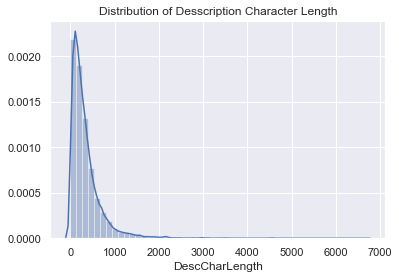

In [107]:
# description character length
df['DescCharLength'] = df.Description.apply(lambda x: len(x))

sns.distplot(df.DescCharLength)
plt.title('Distribution of Desscription Character Length')
plt.show()

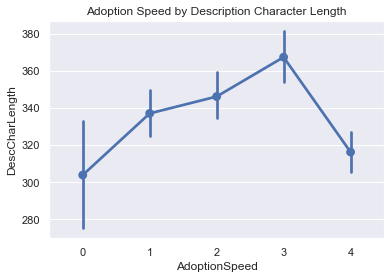

In [108]:
sns.pointplot(df.AdoptionSpeed, df.DescCharLength)
plt.title('Adoption Speed by Description Character Length')
plt.show()

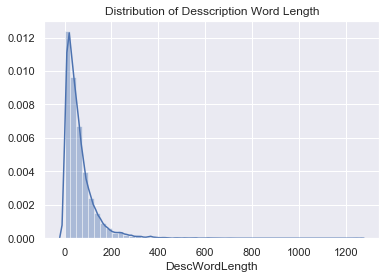

In [109]:
# description word length
df['DescWordLength'] = df.Description.apply(lambda x: len(x.split()))

sns.distplot(df.DescWordLength)
plt.title('Distribution of Desscription Word Length')
plt.show()

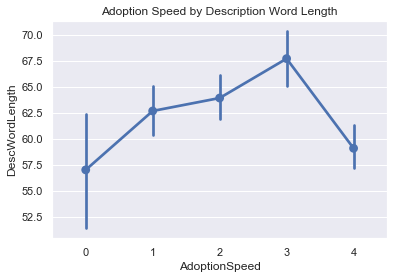

In [110]:
sns.pointplot(df.AdoptionSpeed, df.DescWordLength)
plt.title('Adoption Speed by Description Word Length')
plt.show()

In [111]:
# only keep word characters and whitespaces
desc = df.Description.str.replace('[^\w\s]', '', flags=re.UNICODE)

# remove numbers
desc = desc.str.replace('\d+', '')

# convert to lower case
desc = desc.str.lower()

# remove leading and ending spaces
desc = desc.str.strip()

**Sentiment Analysis**

In [112]:
# sentiment analysis
def nltk_sentiment(text):
    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(text)
    return score

sentiment = desc.apply(lambda x: nltk_sentiment(x))

In [113]:
df['DescNeg'] = sentiment.apply(lambda x: x['neg'])
df['DescNeu'] = sentiment.apply(lambda x: x['neu'])
df['DescPos'] = sentiment.apply(lambda x: x['pos'])
df['DescCompound'] = sentiment.apply(lambda x: x['compound'])

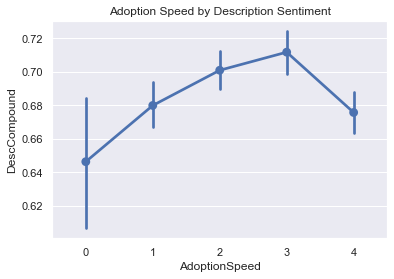

In [114]:
sns.pointplot(df.AdoptionSpeed, df.DescCompound)
plt.title('Adoption Speed by Description Sentiment')
plt.show()

In [115]:
# tokenize
stop_words = set(stopwords.words('english')) 
desc_tokens = desc.apply(lambda x: word_tokenize(x))
filtered_tokens = desc_tokens.apply(lambda x: [w for w in x if not w in stop_words])

In [116]:
# build the bigram and trigram models
bigram = gensim.models.Phrases(filtered_tokens, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[filtered_tokens], threshold=100)  

# faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [117]:
token_bigrams = filtered_tokens.apply(lambda x: bigram_mod[x])

In [118]:
# stemming
stemmer = PorterStemmer()
desc_stem = token_bigrams.apply(lambda x: [stemmer.stem(w) for w in x])

In [119]:
# lemmatization keeping only noun, adj, vb, adv
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(' '.join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

desc_lemmatized = lemmatization(desc_stem, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

**Topic Modeling**

In [121]:
id2word = corpora.Dictionary(desc_lemmatized)
corpus = [id2word.doc2bow(text) for text in desc_lemmatized]

In [123]:
# LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10, 
                                            random_state=SEED,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

In [124]:
lda_model.print_topics()

[(0,
  '0.146*"adopt" + 0.097*"plea" + 0.054*"call" + 0.053*"interest" + 0.052*"month" + 0.051*"old" + 0.034*"vaccin" + 0.033*"contact" + 0.025*"thank" + 0.021*"cute"'),
 (1,
  '0.068*"take" + 0.054*"care" + 0.043*"would" + 0.043*"keep" + 0.029*"get" + 0.026*"help" + 0.026*"go" + 0.023*"know" + 0.023*"could" + 0.022*"hope"'),
 (2,
  '0.180*"be" + 0.124*"eat" + 0.073*"even" + 0.033*"soft" + 0.032*"thing" + 0.028*"happi" + 0.023*"groom" + 0.022*"catch" + 0.020*"afraid" + 0.017*"touch"'),
 (3,
  '0.103*"love" + 0.101*"home" + 0.068*"find" + 0.060*"give" + 0.056*"look" + 0.048*"good" + 0.034*"owner" + 0.028*"hous" + 0.024*"need" + 0.020*"new"'),
 (4,
  '0.068*"small" + 0.066*"long" + 0.044*"fur" + 0.038*"great" + 0.035*"hair" + 0.032*"heart" + 0.029*"tail" + 0.027*"affection" + 0.026*"brother" + 0.025*"size"'),
 (5,
  '0.243*"dog" + 0.047*"run" + 0.034*"grow" + 0.034*"sure" + 0.025*"smart" + 0.025*"sit" + 0.024*"apart" + 0.021*"away" + 0.020*"sister" + 0.019*"enough"'),
 (6,
  '0.117*"peop

In [125]:
# compute perplexity
print('Perplexity: ', lda_model.log_perplexity(corpus)) 

# compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=desc_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -6.8527362411060615
Coherence Score:  0.47814477043998005


In [126]:
mallet_path = 'data/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word, random_seed=SEED)

In [127]:
ldamallet.show_topics(formatted=False)

[(0,
  [('find', 0.1700686541031194),
   ('home', 0.12924480486568676),
   ('hope', 0.042712988987697556),
   ('someon', 0.032391835230152516),
   ('area', 0.03018015942496429),
   ('bring', 0.028429249412523613),
   ('friend', 0.027277334930654748),
   ('give', 0.0268165691379072),
   ('contact', 0.026678339400082938),
   ('good', 0.02400589780214717)]),
 (1,
  [('plea', 0.1637627475190927),
   ('call', 0.10513559244523711),
   ('interest', 0.09255956464078291),
   ('contact', 0.06114236063474642),
   ('black', 0.03347509946494718),
   ('anyon', 0.030136735720492067),
   ('femal', 0.027804454200393288),
   ('fur', 0.023551470251977867),
   ('long', 0.02295696711940367),
   ('male', 0.022911236109205653)]),
 (2,
  [('dog', 0.16095571612216852),
   ('owner', 0.10235382774059133),
   ('good', 0.0986745866394787),
   ('hous', 0.0719890066049027),
   ('walk', 0.02508976461722594),
   ('stay', 0.02482379538100093),
   ('due', 0.02243007225497584),
   ('current', 0.017775610621038166),
   ('

In [128]:
# compute coherence score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=desc_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('Coherence Score: ', coherence_ldamallet)

Coherence Score:  0.5811606345237906


In [143]:
# find the optimal number of topics for LDA
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, random_seed=SEED)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=desc_lemmatized, start=2, limit=20, step=2)

In [144]:
x = range(2, 20, 2)

for m, cv in zip(x, coherence_values):
    print('# Topics =', m, ' has Coherence Value of', round(cv, 4))

# Topics = 2  has Coherence Value of 0.57
# Topics = 4  has Coherence Value of 0.5908
# Topics = 6  has Coherence Value of 0.5894
# Topics = 8  has Coherence Value of 0.5809
# Topics = 10  has Coherence Value of 0.5812
# Topics = 12  has Coherence Value of 0.5564
# Topics = 14  has Coherence Value of 0.534
# Topics = 16  has Coherence Value of 0.555
# Topics = 18  has Coherence Value of 0.5362


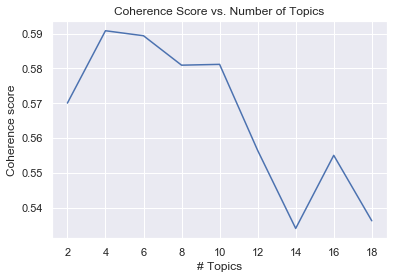

In [145]:
plt.plot(x, coherence_values)
plt.title('Coherence Score vs. Number of Topics')
plt.xlabel('# Topics')
plt.ylabel('Coherence score')
plt.show()

In [148]:
# select the 4 topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.079*"find" + 0.038*"home" + 0.028*"hous" + 0.018*"bring" + 0.016*"hope" + 0.016*"give" + 0.015*"vet" + 0.015*"live" + 0.014*"peopl" + 0.014*"stay"'),
 (1,
  '0.144*"adopt" + 0.098*"plea" + 0.072*"home" + 0.051*"interest" + 0.041*"month" + 0.039*"call" + 0.036*"vaccin" + 0.035*"contact" + 0.022*"spay" + 0.018*"deworm"'),
 (2,
  '0.071*"love" + 0.063*"dog" + 0.056*"good" + 0.040*"owner" + 0.033*"care" + 0.032*"give" + 0.029*"time" + 0.018*"make" + 0.016*"year" + 0.012*"due"'),
 (3,
  '0.068*"play" + 0.053*"love" + 0.046*"cat" + 0.028*"food" + 0.022*"cute" + 0.019*"mother" + 0.018*"give" + 0.017*"eat" + 0.017*"littl" + 0.015*"long"')]

In [150]:
pyLDAvis.enable_notebook()
vis_optimal_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
pyLDAvis.gensim.prepare(vis_optimal_model, corpus, id2word, sort_topics=False)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.161284 -0.354774       1        1  25.682220
1     -0.282396  0.244541       2        1  24.243107
2      0.317921 -0.010537       3        1  25.619376
3      0.125760  0.120771       4        1  24.455297, topic_info=      Term         Freq        Total Category  logprob  loglift
24   adopt  9607.000000  9607.000000  Default  30.0000  30.0000
55    plea  6686.000000  6686.000000  Default  29.0000  29.0000
18    find  5561.000000  5561.000000  Default  28.0000  28.0000
11    play  4596.000000  4596.000000  Default  27.0000  27.0000
137    dog  4471.000000  4471.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
7    month   713.971753  3467.451914   Topic4  -4.5470  -0.1720
299  train   538.588448  1192.537099   Topic4  -4.8289   0.6134
1     care   640.584412  2998.986798   Topic4  -4.6555  -0.1353
19    home   756.262763  8259.376636   Topic4  -4.4894  -0.9824
26    call   616.951201  3220.483387   Topic4  -4.6930  -0.2442

[311 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
263       3  1.000611    abandon
3562      4  0.803953       abil
518       1  0.999554        abl
161       4  1.001197      activ
24        2  1.000046      adopt
...     ...       ...        ...
1921      2  1.102605  weighs_kg
121       2  1.000614   whatsapp
479       4  1.001052      white
3572      4  1.004942     whitey
269       3  1.000058       year

[314 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

In [151]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=desc.values.tolist()):
    sent_topics_df = pd.DataFrame()

    # get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ', '.join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts, name='Description')
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

topic_df = format_topics_sentences(optimal_model, corpus, desc.values.tolist())

In [152]:
topic_df.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Description
0,2.0,0.2937,"love, dog, good, owner, care, give, time, make...",nibble is a month old ball of cuteness he is ...
1,0.0,0.3094,"find, home, hous, bring, hope, give, vet, live...",i just found it alone yesterday near my apartm...
2,1.0,0.3068,"adopt, plea, home, interest, month, call, vacc...",their pregnant mother was dumped by her irresp...
3,2.0,0.2636,"love, dog, good, owner, care, give, time, make...",good guard dog very alert active obedience wai...
4,3.0,0.2971,"play, love, cat, food, cute, mother, give, eat...",this handsome yet cute boy is up for adoption ...


In [153]:
df = pd.concat([df, topic_df.Dominant_Topic], axis=1)

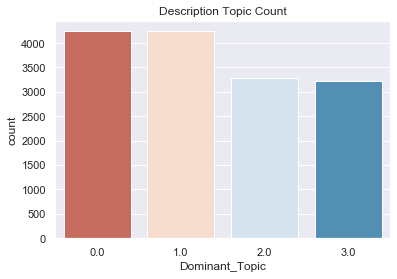

In [154]:
sns.countplot(df.Dominant_Topic, palette='RdBu')
plt.title('Description Topic Count')
plt.show()

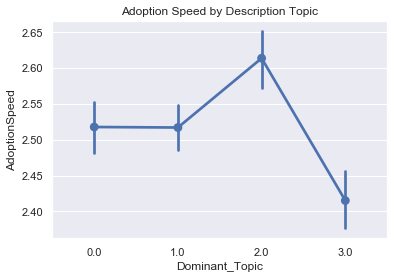

In [155]:
sns.pointplot(df.Dominant_Topic, df.AdoptionSpeed)
plt.title('Adoption Speed by Description Topic')
plt.show()

In [156]:
topic_dummy = pd.get_dummies(df.Dominant_Topic.astype(str), prefix='Topic')
df.drop('Dominant_Topic', axis=1, inplace=True)
df = pd.concat([df, topic_dummy], axis=1)

In [157]:
# group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = topic_df.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                             axis=0)

# reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5049,"find, home, hous, bring, hope, give, vet, live...",it was late at night when i was about to leave...
1,1.0,0.5174,"adopt, plea, home, interest, month, call, vacc...",for adoption or further enquiries please kindl...
2,2.0,0.5741,"love, dog, good, owner, care, give, time, make...",gabby is a beautiful sleek black puppy estimat...
3,3.0,0.4926,"play, love, cat, food, cute, mother, give, eat...",adorable domestic long hair mix medium hair ki...


In [158]:
# most popular topic: little, cute, female cat
sent_topics_sorteddf_mallet.iloc[3, 2]

'play, love, cat, food, cute, mother, give, eat, littl, long'

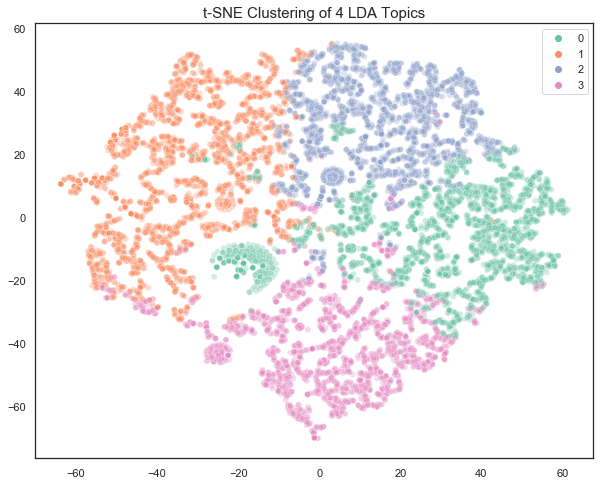

In [160]:
# get topic weights
topic_weights = []
for i, row_list in enumerate(optimal_model[corpus]):
    topic_weights.append([w for i, w in row_list])

# array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# plot the Topic Clusters using Bokeh
sns.set_style('white')
plt.figure(figsize=(10, 8))
xs = tsne_lda[:,0]
ys = tsne_lda[:,1]
sns.scatterplot(xs, ys, hue=topic_num, palette=sns.color_palette('Set2', 4), legend='full', alpha=0.3)
plt.title('t-SNE Clustering of 4 LDA Topics', fontsize=15)
plt.show()

**TFIDF**

In [161]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3),
                             stop_words='english', 
                             max_features=None,
                             analyzer='word',
                             strip_accents='unicode',
                             lowercase=True,
                             token_pattern=r'\b[a-zA-Z]{3,}\b',
                             max_df=0.5, 
                             min_df=2)
dtm_tfidf = vectorizer.fit_transform(df.Description)

svd = TruncatedSVD(n_components=20, random_state=SEED)
tfidf = svd.fit_transform(dtm_tfidf)
tfidf_df = pd.DataFrame(tfidf)

In [162]:
df = pd.concat([df, tfidf_df], axis=1)
df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,ColorNum,NoName,PureBreed,Pure_BreedScore,Pure_BreedName,Breed1_name,Breed2_name,Tabby,Domestic_Short_Hair,Domestic_Medium_Hair,Labrador_Retriever,Terrier,Mixed_Breed,Other,Color_Black,Color_Brown,Color_Cream,Color_Golden,Color_Gray,Color_White,Color_Yellow,State_Johor,State_Kuala Lumpur,State_Other,State_Perak,State_Pulau Pinang,State_Selangor,DescLang,DescCharLength,DescWordLength,DescNeg,DescNeu,DescPos,DescCompound,Topic_0.0,Topic_1.0,Topic_2.0,Topic_3.0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,2,0,1,299,Tabby,Tabby,Pure,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,en,359,69,0.000,0.742,0.258,0.9552,0,0,1,0,0.016076,0.058597,-0.055910,-0.015893,-0.008423,-0.002062,-0.004293,-0.013681,-0.004222,-0.000916,0.009754,-0.002826,-0.018925,-0.012456,0.000584,-0.014139,-0.007550,0.018987,0.009588,0.009349
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,2,1,1,265,Domestic_Medium_Hair,Domestic_Medium_Hair,Pure,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,en,118,23,0.149,0.723,0.129,0.1280,1,0,0,0,0.012854,0.053619,-0.039041,-0.005173,-0.006618,-0.017037,0.013809,0.003259,-0.031320,-0.025153,-0.010259,0.008178,0.010272,0.003087,-0.001423,-0.005038,-0.003081,0.009825,0.003104,0.006718
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,2,0,0,0,Mixed_Breed,Mixed_Breed,Pure,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,en,393,69,0.095,0.706,0.200,0.7650,0,1,0,0,0.024339,0.126591,0.022879,0.001516,-0.000647,0.160074,-0.078973,0.080790,-0.122201,-0.013678,0.044125,-0.050633,0.041106,0.008243,0.024158,-0.030801,0.012797,-0.050066,-0.023363,-0.057766
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,2,0,0,0,Mixed_Breed,Mixed_Breed,Pure,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,en,146,25,0.000,0.490,0.510,0.9494,0,0,1,0,0.027515,0.083978,-0.066580,0.060781,0.003319,0.012807,0.019661,0.055596,-0.021154,0.016499,-0.000498,0.044688,-0.034980,0.002213,-0.094938,0.060292,0.026551,-0.040345,-0.087958,0.000022
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,1,0,0,0,Mixed_Breed,Mixed_Breed,Pure,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,en,390,81,0.000,0.635,0.365,0.9880,0,0,0,1,0.077630,0.093819,-0.062051,-0.024341,-0.009130,-0.025289,0.014702,0.026713,-0.031594,0.069479,-0.009017,0.015145,0.099046,0.026728,0.011302,0.002314,0.000365,0.017789,0.066420,0.038391


In [163]:
df.drop(['Name', 'Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'State', 'RescuerID', 'Description', 'DescLang', 'Pure_BreedScore', 'Pure_BreedName', 'Breed1_name',
         'Breed2_name'], axis=1, inplace=True)
df.set_index('PetID', inplace=True)
df.head()

,Type,Age,Gender,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,VideoAmt,PhotoAmt,AdoptionSpeed,ColorNum,NoName,PureBreed,Tabby,Domestic_Short_Hair,Domestic_Medium_Hair,Labrador_Retriever,Terrier,Mixed_Breed,Other,Color_Black,Color_Brown,Color_Cream,Color_Golden,Color_Gray,Color_White,Color_Yellow,State_Johor,State_Kuala Lumpur,State_Other,State_Perak,State_Pulau Pinang,State_Selangor,DescCharLength,DescWordLength,DescNeg,DescNeu,DescPos,DescCompound,Topic_0.0,Topic_1.0,Topic_2.0,Topic_3.0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
PetID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
86e1089a3,2,3,1,1,1,2,2,2,1,1,100,0,1.0,2,2,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,359,69,0.000,0.742,0.258,0.9552,0,0,1,0,0.016076,0.058597,-0.055910,-0.015893,-0.008423,-0.002062,-0.004293,-0.013681,-0.004222,-0.000916,0.009754,-0.002826,-0.018925,-0.012456,0.000584,-0.014139,-0.007550,0.018987,0.009588,0.009349
6296e909a,2,1,1,2,2,3,3,3,1,1,0,0,2.0,0,2,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,118,23,0.149,0.723,0.129,0.1280,1,0,0,0,0.012854,0.053619,-0.039041,-0.005173,-0.006618,-0.017037,0.013809,0.003259,-0.031320,-0.025153,-0.010259,0.008178,0.010272,0.003087,-0.001423,-0.005038,-0.003081,0.009825,0.003104,0.006718
3422e4906,1,1,1,2,2,1,1,2,1,1,0,0,7.0,3,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,393,69,0.095,0.706,0.200,0.7650,0,1,0,0,0.024339,0.126591,0.022879,0.001516,-0.000647,0.160074,-0.078973,0.080790,-0.122201,-0.013678,0.044125,-0.050633,0.041106,0.008243,0.024158,-0.030801,0.012797,-0.050066,-0.023363,-0.057766
5842f1ff5,1,4,2,2,1,1,1,2,1,1,150,0,8.0,2,2,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,146,25,0.000,0.490,0.510,0.9494,0,0,1,0,0.027515,0.083978,-0.066580,0.060781,0.003319,0.012807,0.019661,0.055596,-0.021154,0.016499,-0.000498,0.044688,-0.034980,0.002213,-0.094938,0.060292,0.026551,-0.040345,-0.087958,0.000022
850a43f90,1,1,1,2,1,2,2,2,1,1,0,0,3.0,2,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,390,81,0.000,0.635,0.365,0.9880,0,0,0,1,0.077630,0.093819,-0.062051,-0.024341,-0.009130,-0.025289,0.014702,0.026713,-0.031594,0.069479,-0.009017,0.015145,0.099046,0.026728,0.011302,0.002314,0.000365,0.017789,0.066420,0.038391


In [164]:
df.shape

(14993, 67)

In [166]:
df.to_csv('data/clean_features.csv')